# $\sqrt{i\text{SWAP}}$ gate in superconducting qubits

In this notebook, we design optimal pulses to realize a high fidelity $16ns$ $\sqrt{i\text{SWAP}}$ gate, we minimize the leakage out of computational space. We model a system of two flux tunable transmons with the following Hamiltonian,

$$H = \left[\omega_1 + f_1(t)\right] a_1^{\dagger} a_1 + \frac{\eta_1}{12} \left[a_1^{\dagger} + a_1\right]^4 + \left[\omega_2 + f_2(t)\right] a_2^{\dagger} a_2 + \frac{\eta_2}{12} \left[a_2^{\dagger} + a_2\right]^4 + g(t) (a_1 - a_1^{\dagger}) (a_2 - a_2^{\dagger})  $$

In [1]:
using Sisyphus
using QuantumOptics
using LinearAlgebra
using Flux, DiffEqFlux
using Plots
using OrdinaryDiffEq: DP5, Tsit5, Vern7, Vern9, BS3
using Random
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear);

In [2]:
ω₁ = 2π*5.0
η₁ = -2π*300.0*1e-3
ω₁ += η₁

ω₂ = 2π*5.0

η₂ = -2π*300.0*1e-3
ω₂ += η₂

ωlo1 = ω₂
ωlo2 = ω₁;

here we consider the first 6 levels of each transmon

In [3]:
n_levels = 6
bs = FockBasis(n_levels-1)
id = identityoperator(bs)

a1 = destroy(bs)⊗id
a1d = create(bs)⊗id
a2 = id⊗destroy(bs)
a2d = id⊗create(bs)
id12 = id⊗id;

In [4]:
H0 = (η₁/12.0)*(a1 + a1d)^4 + (η₂/12.0)*(a2 + a2d)^4 ## anharmonic part
H1 = (a2 - a2d)*(a1 - a1d) ## capacitive coupling
H2 = a1d*a1 + 0.5*id12
H3 = a2d*a2 + 0.5*id12
t0, t1 = 0.0, 16.0;

In [5]:
Random.seed!(3)
n_neurons = 8
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, 3))
θ = Vector{Float64}(initial_params(ann))     
n_params = length(θ)

187

we first pretrain the neural networks to produce gaussian pulses

In [6]:
g_guess(t) = @. 0.01*2π*exp(-(t-0.5*t1)^2/(0.2*t1)^2)
f1_guess(t) = @. 0.1*2π*exp(-(t-0.5*t1)^2/(0.2*t1)^2)
f2_guess(t) = @. 0.1*2π*exp(-(t-0.5*t1)^2/(0.2*t1)^2)

tsf32 = Float32(t0):0.1f0:Float32(t1)
gs = Vector{Float32}(g_guess(tsf32))
f1s = Vector{Float32}(f1_guess(tsf32))
f2s = Vector{Float32}(f2_guess(tsf32))

ts = Vector{Float64}(tsf32)
function loss(p)
    c = 0.0f0
    for (i,t) in enumerate(tsf32)
        x = ann([t], p)
        c += (x[1] - gs[i])^2
        c += (x[2] - f1s[i])^2
        c += (x[3] - f2s[i])^2
    end
   # println(c)
    c
end

res = DiffEqFlux.sciml_train(loss, initial_params(ann), ADAM(0.1f0), maxiters = 500)
θ = Vector{Float64}(res.u);

In [7]:
coeffs(p, t) = let v=ann([t], p)
                    [v[1], ω₁ + v[2], ω₂ + v[3]]
               end 

H = Hamiltonian(H0, [H1, H2, H3], coeffs);

In [8]:
states = [fockstate(bs, 0)⊗fockstate(bs, 0),
          fockstate(bs, 0)⊗fockstate(bs, 1),
          fockstate(bs, 1)⊗fockstate(bs, 0),
          fockstate(bs, 1)⊗fockstate(bs, 1)]

trans = UnitaryTransform(states, [[1 0 0 0];
                                  [0 1 1.0im 0]/√2;
                                  [0 1.0im 1 0]/√2;
                                  [0 0.0 0.0 1.0]]);

In [9]:
bcs(p) = 2.0*sum(ann([t0], p).^2 + ann([t1], p).^2)
                 
cost = CostFunction((x,y)-> 1.0-real(x'*y), bcs);

In [10]:
prob = QOCProblem(H, trans,(t0, t1), cost);

here we use the gaussian pulses as initial guess and solve the `QOCProblem`

In [11]:
sol = solve(prob, θ, ADAM(0.01); maxiter=100);

Progress: 100%|█████████████████████████████████████████| Time: 0:54:37
  distance:     0.008841084452384546
  constraints:  0.0003239125678191379


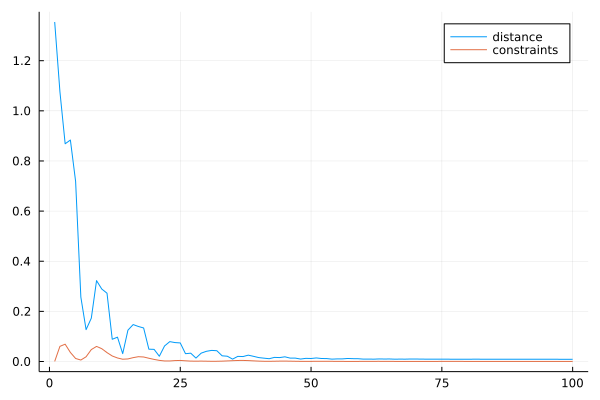

In [12]:
plot(sol.distance_trace, label="distance")
plot!(sol.constraints_trace, label="constraints")

optimal pulses to tune the flux lines and capacitive coupling

In [13]:
g(t) = ann([t], sol.params)[1]/2π
f1(t) = ann([t], sol.params)[2]/2π
f2(t) = ann([t], sol.params)[3]/2π;

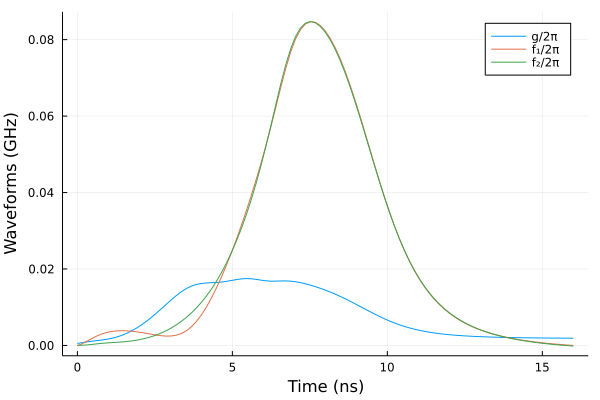

In [14]:
ts = t0:t1/100:t1
plot(ts, g.(ts), label="g/2π")
plot!(ts, f1.(ts), label="f₁/2π")
plot!(ts, f2.(ts), label="f₂/2π")
xlabel!("Time (ns)")
ylabel!("Waveforms (GHz)")